In [1]:
#Ensure dependencies are compatible versions
!pip uninstall keras-nightly
!pip uninstall -y tensorflow

%tensorflow_version 1.x
!pip install tensorflow-gpu==1.14.0

!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda=9.0.176-1
!pip install keras==2.1.6
!pip install h5py==2.10.0
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()

TensorFlow 1.x selected.
--2021-09-26 20:56:04--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.20.126
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.20.126|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb [following]
--2021-09-26 20:56:04--  https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64.deb?kJioZf66eib7ttmmonU51XHkhb84_UQKDr-MpQRXFVQdp7zi5soNGY4m_Hrv-sqBaYd7

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0


'/device:GPU:0'

In [2]:
#Mount drive containing images and annotations via Google Drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!ls
%cd gdrive/My Drive/Rooftop_detection

Mounted at /content/gdrive
cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb    drive   sample_data
cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb.1  gdrive
/content/gdrive/My Drive/Rooftop_detection


In [3]:
#Navigate to Mask_RCNN folder and run setup
%cd Mask_RCNN
! python setup.py install

/content/gdrive/My Drive/Rooftop_detection/Mask_RCNN
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt


In [4]:
import os
import shutil
import pickle
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import shutil
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log, load_image_gt, mold_image

from rooftops import *

%matplotlib inline 

Using TensorFlow backend.


In [7]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "model/logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "model/mask_rcnn_coco.h5")

DATASET_DIR = os.path.join(ROOT_DIR, "data/maps")

### Loading `train_set`

In [69]:
# Load dataset
train_set = RooftopDataset()
train_set.load_dataset(DATASET_DIR, "train")

# Must call before using the dataset
train_set.prepare()

print("Image Count: {}".format(len(train_set.image_ids)))
print("Polygon Count: {}".format(train_set.num_polygons))
print("Class Count: {}".format(train_set.num_classes))
for i, info in enumerate(train_set.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 69
Polygon Count: 1488
Class Count: 4
  0. BG                                                
  1. roof                                              
  2. pool                                              
  3. sports                                            


### Loading `val_set`

In [70]:
# Load dataset
val_set = RooftopDataset()
val_set.load_dataset(DATASET_DIR, "val")

# Must call before using the dataset
val_set.prepare()

print("Image Count: {}".format(len(val_set.image_ids)))
print("Polygon Count: {}".format(val_set.num_polygons))
print("Class Count: {}".format(val_set.num_classes))
for i, info in enumerate(val_set.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 22
Polygon Count: 545
Class Count: 4
  0. BG                                                
  1. roof                                              
  2. pool                                              
  3. sports                                            


## Model training

In [ ]:
# define a configuration for the model to train
class roofConfig(Config):
    # Give the configuration a recognizable name
    NAME = "roof_cfg"
    # Number of classes (background + roof)
    NUM_CLASSES = 1 + 3
    # Number of training steps per epoch
    STEPS_PER_EPOCH = len(train_set.image_ids)
 
# prepare config
config = roofConfig()
config.display()
epochs = 80

# define the model
model = modellib.MaskRCNN(mode='training', model_dir=MODEL_DIR, config=config)

# load weights (mscoco) for epoch 1
# model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# Load the last model you trained
weights_path = model.find_last()
model.load_weights(weights_path, by_name=True)




Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
# train weights (output layers or 'heads')
model.train(train_set, val_set, learning_rate=config.LEARNING_RATE, epochs=epochs, layers='heads')


Starting at epoch 60. LR=0.001

Checkpoint Path: /content/gdrive/My Drive/Rooftop_detection/model/logs/roof_cfg20210921T2155/mask_rcnn_roof_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4   

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 61/80
68/69 [============================>.] - ETA: 2s - loss: 0.2520 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0355 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.1185

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


69/69 [==============================] - 405s 6s/step - loss: 0.2513 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0353 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.0285 - mrcnn_mask_loss: 0.1183 - val_loss: 1.7951 - val_rpn_class_loss: 0.1440 - val_rpn_bbox_loss: 0.3222 - val_mrcnn_class_loss: 0.6561 - val_mrcnn_bbox_loss: 0.3079 - val_mrcnn_mask_loss: 0.3649
Epoch 62/80
69/69 [==============================] - 276s 4s/step - loss: 0.2596 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0356 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.0284 - mrcnn_mask_loss: 0.1197 - val_loss: 1.7124 - val_rpn_class_loss: 0.1606 - val_rpn_bbox_loss: 0.3111 - val_mrcnn_class_loss: 0.5945 - val_mrcnn_bbox_loss: 0.2914 - val_mrcnn_mask_loss: 0.3548
Epoch 63/80
69/69 [==============================] - 279s 4s/step - loss: 0.2489 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0334 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.1152 - val_loss: 1.8214 - val_rpn_class_loss: 0.1498 - v

## Predict

In [8]:
# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "roof_cfg"
	# number of classes (background + roof)
	NUM_CLASSES = 1 + 3
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

# create config
cfg = PredictionConfig()
# define the model
model = modellib.MaskRCNN(mode='inference', model_dir=MODEL_DIR, config=cfg)

# load last trained model weights
# model.load_weights(model.find_last(), by_name=True) #latest model weights

# load an specific model weights
best_model_path = os.path.join(ROOT_DIR, "model/logs/roof_cfg20210921T2155/mask_rcnn_roof_cfg_0060.h5")
model.load_weights(best_model_path, by_name=True)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 60


In [12]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

image ID: dataset.arguelles 2021-09-12 163324.png (3) /content/gdrive/My Drive/Rooftop_detection/data/maps/val/arguelles 2021-09-12 163324.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (15,)                 min:    1.00000  max:    1.00000  int64
gt_bbox                  shape: (15, 4)               min:   56.00000  max: 1023.00000  int32
gt_mask                  shape: (1024, 1024, 15)      min:    0.00000  max:    1.00000  bool


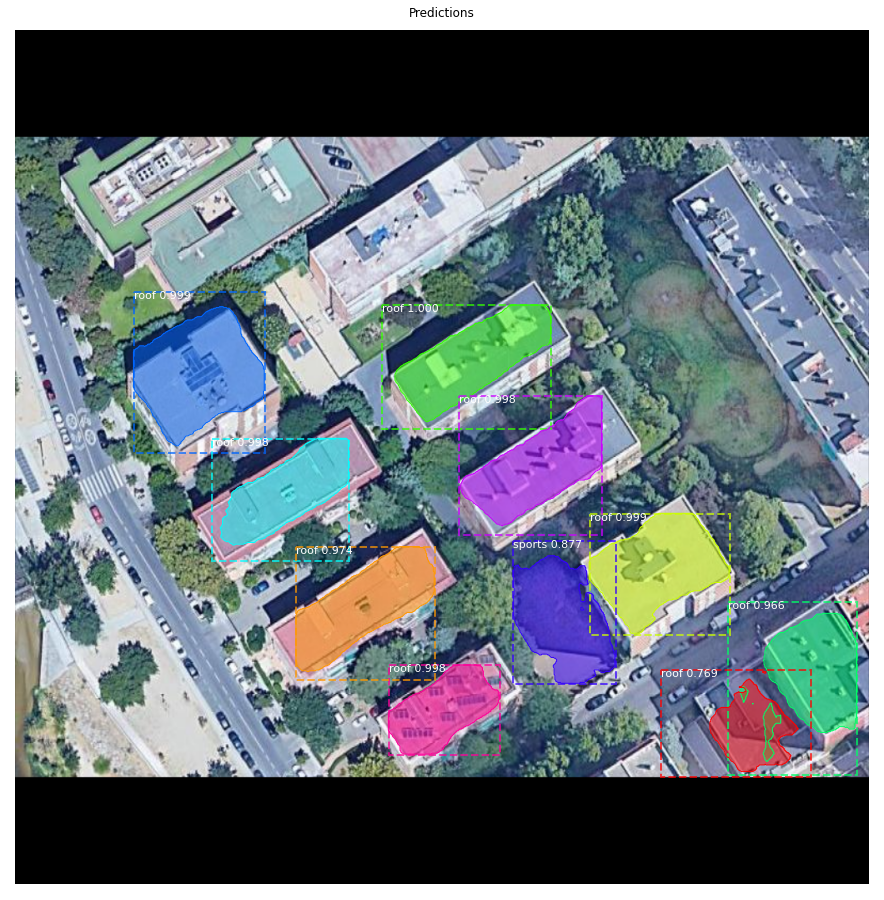

In [ ]:
image_id = random.choice(val_set.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(val_set, cfg, image_id, use_mini_mask=False)
info = val_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       val_set.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            val_set.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Model evaluation

In [5]:
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = np.expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = np.mean(APs)
    return mAP

In [71]:
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)

# evaluate model on val dataset
val_mAP = evaluate_model(val_set, model, cfg)
print("Val mAP: %.3f" % val_mAP)

Train mAP: 0.720
Val mAP: 0.527


## Compute mAP @ IoU=50 on Models for different epochs

In [11]:
# Read all models at a logs directory
def load_list_models(path):
    files = []
    for file in os.listdir(path):
        if file.endswith('.h5'):
            files.append(file)
    return files

In [20]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "roof_cfg"
    # number of classes (background + roof)
    NUM_CLASSES = 1 + 3
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# create config
cfg = PredictionConfig()

# Root directory of the project
ROOT_DIR = os.path.abspath("")

# define the model
model = modellib.MaskRCNN(mode='inference', model_dir=MODEL_DIR, config=cfg)

# logs directory selected
MODELS_TRAINED_DIR = MODEL_DIR + '/roof_cfg20210921T2155'

# initialize df
mAPs_df = pd.DataFrame(columns=['model_file', 'epoch', 'train_mAP', 'val_mAP'])

In [ ]:
for model_name in load_list_models(MODELS_TRAINED_DIR):
    # Setting the range of models to read
    epoch = int(model_name[-5:-3])
    if epoch <= 40:
        
        model_path = os.path.join(MODELS_TRAINED_DIR, model_name)
        
        # load trained model weights
        model.load_weights(model_path, by_name=True)
        
        
        train_mAP = evaluate_model(train_set, model, cfg)        
        val_mAP = evaluate_model(val_set, model, cfg)
        
        print("Epoch:", epoch, "--> Train mAP @ IoU=50:", train_mAP)
        print("Epoch:", epoch, "--> Val   mAP @ IoU=50:", val_mAP)
        
        mAPs_df = mAPs_df.append({'model_file': model_name,
                                  'epoch': epoch,
                                  'train_mAP': train_mAP,
                                  'val_mAP': val_mAP},
                                 ignore_index=True)
mAPs_df

Re-starting from epoch 2
Epoch: 2 --> Train mAP @ IoU=50: 0.3462822628304712
Epoch: 2 --> Val   mAP @ IoU=50: 0.4041050493055962
Re-starting from epoch 1


In [19]:
mAPs_df.to_csv('mAPs_df_1-20.csv')

# Test best model on a test dataset of isolated houses

### Loading `test_set`

In [64]:
# Load dataset
test_set = RooftopDataset()
test_set.load_dataset(DATASET_DIR, "test")

# Must call before using the dataset
test_set.prepare()

print("Image Count: {}".format(len(test_set.image_ids)))
print("Polygon Count: {}".format(test_set.num_polygons))
print("Class Count: {}".format(test_set.num_classes))
for i, info in enumerate(test_set.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 11
Polygon Count: 258
Class Count: 4
  0. BG                                                
  1. roof                                              
  2. pool                                              
  3. sports                                            


In [65]:
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Train mAP: %.3f" % test_mAP)

Train mAP: 0.624


image ID: dataset.colmenar 2021-09-24 164405.png (2) /content/gdrive/My Drive/Rooftop_detection/data/maps/test/colmenar 2021-09-24 164405.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (22,)                 min:    1.00000  max:    3.00000  int64
gt_bbox                  shape: (22, 4)               min:   11.00000  max: 1023.00000  int32
gt_mask                  shape: (1024, 1024, 22)      min:    0.00000  max:    1.00000  bool


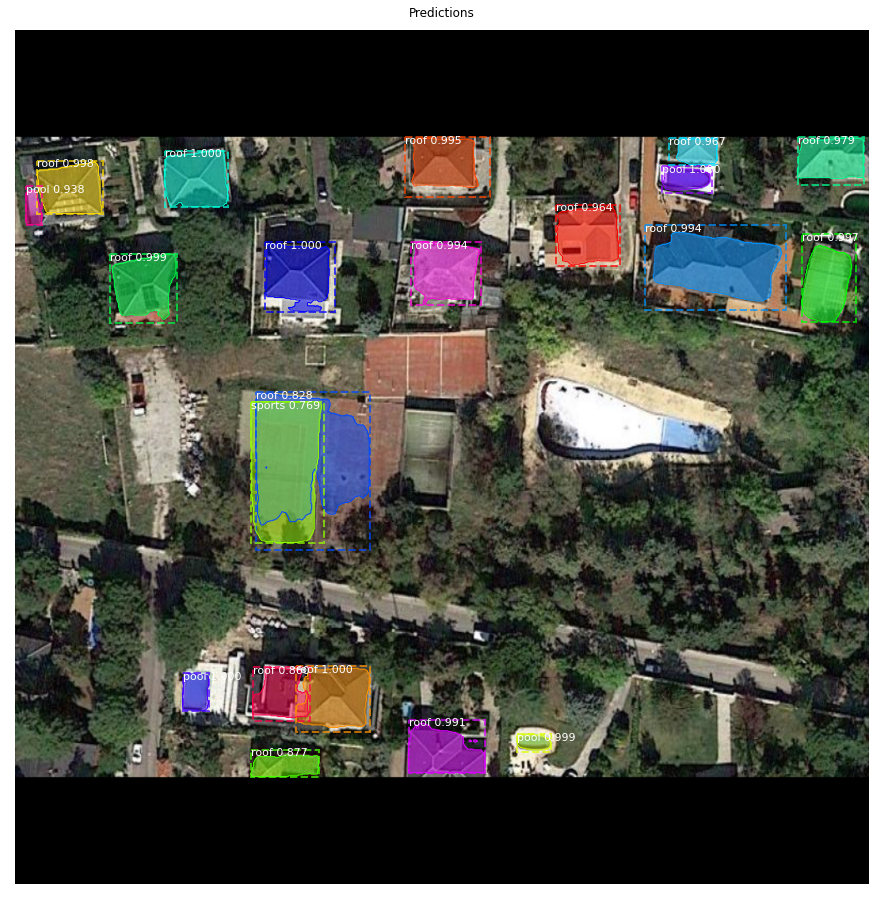

In [66]:
image_id = random.choice(test_set.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_set, cfg, image_id, use_mini_mask=False)
info = test_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       test_set.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

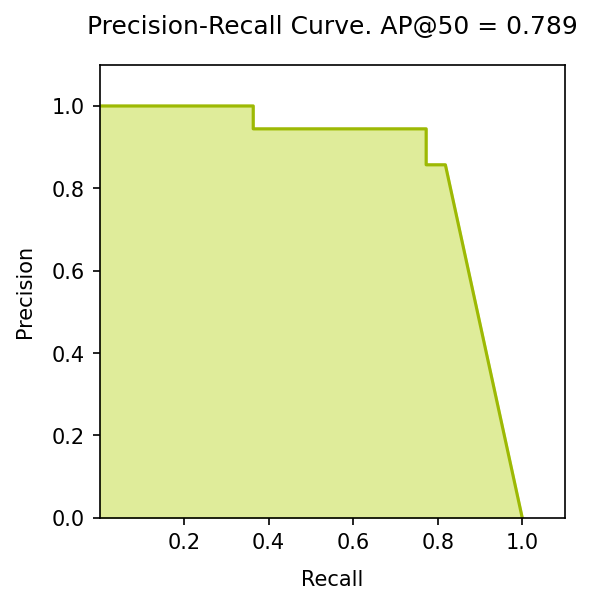

In [67]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])

# Plot the Precision-Recall curve
fig, ax = plt.subplots(1, figsize=(4, 4), dpi=150)
ax.set_title("Precision-Recall Curve. AP@50 = {:.3f}".format(AP), pad=15)
plt.xlabel('Recall', labelpad=8)
plt.xticks([0.2, 0.4, 0.6, 0.8, 1])
plt.ylabel('Precision', labelpad=8)
ax.set_ylim(0, 1.1)
ax.set_xlim(0, 1.1)
plt.fill_between(recalls, precisions, color = '#B1D004', alpha=0.4)
_ = ax.plot(recalls, precisions, color = '#9DB904')

plt.savefig('AUC-PR_test_01.png', bbox_inches='tight', transparent=True)